In [22]:
###Kaggle APT Matches
#https://www.kaggle.com/sijovm/atpdata

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [24]:
df =pd.read_csv('atpdata/ATP.csv')

In [25]:
#df.info()

In [26]:
#df.describe()

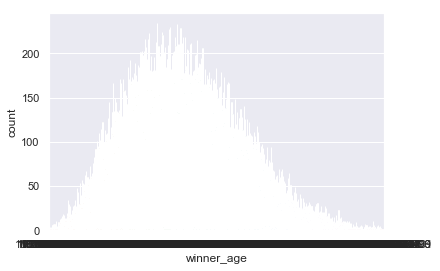

In [27]:
sns.set(style="darkgrid")
ax = sns.countplot(x="winner_age", data=df)

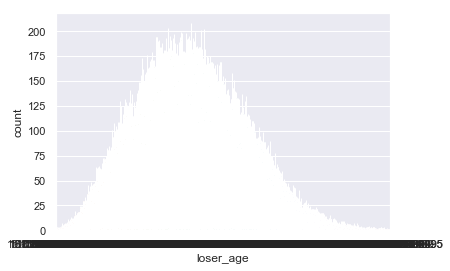

In [28]:
sns.set(style="darkgrid")
ax = sns.countplot(x="loser_age", data=df)

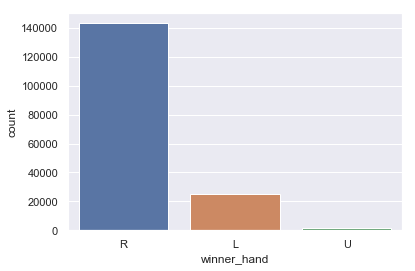

In [30]:
sns.set(style="darkgrid")
ax = sns.countplot(x="winner_hand", data=df)

[Text(0, 0.5, 'number of matches')]

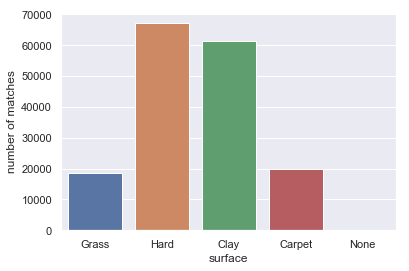

In [29]:
sns.set(style="darkgrid")
ax = sns.countplot(x="surface", data=df)
ax.set(ylabel ="number of matches")

In [31]:
#creating the target

def createTarget(df):
    #split dataframe in half to create the target where player 1 wins
    df1 = df.loc[:84844,:]
    df2 = df.loc[84845:,:]
    #in df1, player 1 = loser so target = 0
    #in df2, player 1, = winner (because we switched them) so target = 1
    df2.rename(columns={"l_1stIn" : "w_1stIn", 
                    "l_1stWon" : "w_1stWon",
                    "l_2ndWon" : "w_2ndWon",
                    "l_SvGms" : "w_SvGms",
                    "l_ace" : "w_ace",
                    "l_bpFaced" : "w_bpFaced",
                    "l_bpSaved" : "w_bpSaved",
                    "l_df" : "w_df",
                    "l_svpt" : "w_svpt",
                    "loser_age" : "winner_age",
                    "loser_entry" : "winner_entry",
                    "loser_hand" : "winner_hand",
                    "loser_ht" : "winner_ht",
                    "loser_id" : "winner_id",
                    "loser_ioc" : "winner_ioc",
                    "loser_rank" : "winner_rank",
                    "loser_rank_points" : "winner_rank_points",
                    "loser_seed" : "winner_seed",
                    "w_1stIn" : "l_1stIn", 
                    "w_1stWon" : "l_1stWon",
                    "w_2ndWon" : "l_2ndWon",
                    "w_SvGms" : "l_SvGms",
                    "w_ace" : "l_ace",
                    "w_bpFaced" : "l_bpFaced",
                    "w_bpSaved" : "l_bpSaved",
                    "w_df" : "l_df",
                    "w_svpt" : "l_svpt",
                    "winner_age" : "loser_age",
                    "winner_entry" : "loser_entry",
                    "winner_hand" : "loser_hand",
                    "winner_ht" : "loser_ht",
                    "winner_id" : "loser_id",
                    "winner_ioc" : "loser_ioc",
                    "winner_rank" : "loser_rank",
                    "winner_rank_points" : "loser_rank_points",
                    "winner_seed" : "loser_seed",
                   }, inplace=True)

    df1['target'] = 0
    df2['target'] = 1

    df = df1.append(df2, sort=True)
    
    return df

In [32]:
df = createTarget(df)

df['target'].value_counts()

c:\users\natacha\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
c:\users\natacha\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\natacha\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

1    84845
0    84845
Name: target, dtype: int64

In [34]:
#preprocessing the data

def prepareData(df):
    
    #columns to drop : tourney_name - duplicate of Tourney_id, draw_size - not enought data 1K
    columnsToDrop = ["tourney_id", "tourney_name", "draw_size", "score", "winner_name", "loser_name"]

    df.drop(columnsToDrop, axis=1, inplace=True)

    #columns to drop because limited RAM on computer
    columnsToDropRam = ["winner_seed", "loser_seed", "loser_ioc", "winner_ioc", "loser_entry", "winner_entry" ]
    
    df.drop(columnsToDropRam, axis=1, inplace=True)


    #Replace missing values

    #replace value with mean value
    columns_mean = ["l_1stIn", "w_1stIn", "l_1stWon", "w_1stWon", "l_2ndWon", "w_2ndWon", 
                "l_SvGms", "w_SvGms", "l_bpSaved", "w_bpSaved", "l_bpFaced", "w_bpFaced", "l_ace", 
                "w_ace", "l_df", "w_df", "l_svpt", "w_svpt", "loser_age", "winner_age", "loser_ht", 
                "winner_ht", "loser_rank", "winner_rank", "loser_rank_points", "winner_rank_points", "minutes"]

    for column in columns_mean:
        df[column] = df[column].fillna(np.mean(df[column]))

    #replace empty entry, hand
    df["loser_hand"] = df["loser_hand"].fillna("L")
    df["winner_hand"] = df["winner_hand"].fillna("L")
    df["surface"] = df["surface"].fillna("NA")

    columns_dummies = ["loser_hand", "winner_hand",
                       "round", "surface", "tourney_level" ]

    #convert object columns to numerical
    le = preprocessing.LabelEncoder()

    for column in columns_dummies:
        le.fit(df[column])
        df[column] = le.transform(df[column])

    # columns to one hot encode : 
    df = pd.get_dummies(df, columns=columns_dummies, drop_first=True)
    
    return df

In [33]:
df = prepareData(df)

#df.info()

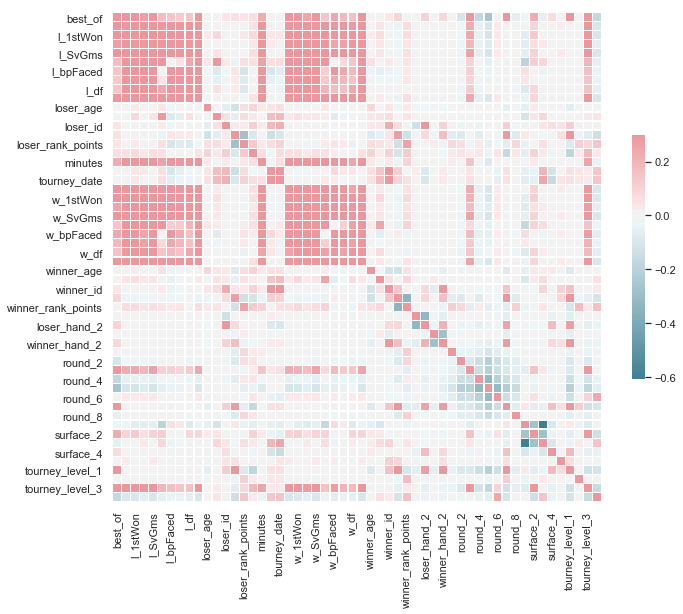

In [44]:
sns.set(style="white")
corrMatrix = df.corr()

f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corrMatrix, cmap=cmap, vmax=.3, center=0, square=True, linewidth=.25, cbar_kws={"shrink": .5})

In [35]:
'''
for column in df.columns:
    print('column name ', column, ' : ', df[column].value_counts() )
'''

"\nfor column in df.columns:\n    print('column name ', column, ' : ', df[column].value_counts() )\n"

In [38]:
#prepare train and test data set
y = df['target']
X = df.drop(['target'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [37]:
#random forest classifier
model_lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_lr.fit(X_train, y_train)

print('train model score : ', model_lr.score(X_train, y_train))


predicted_lr = model_lr.predict(X_test)

# generate class probabilities
probs = model_lr.predict_proba(X_test)

# generate evaluation metrics
print ('test accuracy : ', metrics.accuracy_score(y_test, predicted_lr))
print ('ROC AUC score : ', metrics.roc_auc_score(y_test, probs[:, 1]))

train model score :  0.8417742673187207
test accuracy :  0.8419943569413193
ROC AUC score :  0.9095947561726635


In [36]:
#Random Forest Classifier
model_rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model_rfc.fit(X_train, y_train)

print('train model score : ', model_rfc.score(X_train, y_train))


predicted_rfc = model_rfc.predict(X_test)

# generate class probabilities
probs = model_rfc.predict_proba(X_test)

# generate evaluation metrics
print ('test accuracy : ', metrics.accuracy_score(y_test, predicted_rfc))
print ('ROC AUC score : ', metrics.roc_auc_score(y_test, probs[:, 1]))

train model score :  0.9815642261548746
test accuracy :  0.9815350548233865
ROC AUC score :  0.9997591622659439


In [39]:
#GaussianNB
model_gnb = GaussianNB()
model_gnb.fit(X_train, y_train)

print('train model score : ', model_gnb.score(X_train, y_train))


predicted_gnb = model_gnb.predict(X_test)

# generate class probabilities
probs = model_gnb.predict_proba(X_test)

# generate evaluation metrics
print ('test accuracy : ', metrics.accuracy_score(y_test, predicted_gnb))
print ('ROC AUC score : ', metrics.roc_auc_score(y_test, probs[:, 1]))

train model score :  0.8868785842451535
test accuracy :  0.8860852173291903
ROC AUC score :  0.9607766551065575


In [40]:
#cross validation on randon forest
scores = cross_val_score(model_rfc, X, y, cv=5)
print(np.mean(scores))

0.9175201838646944
